# Implementação de Rede Neural com sigmoid e gradiente descendente
O presente código desenvolve a lógica aplicada no algoritmo de regressão logística e implementa uma rede neural com uma camada oculta para os dados apresentados na regressão logística a fim de comparar a acurácia obtida.

A rede neural consiste em três camadas: uma **camada de entrada**, uma **camada oculta** e uma **camada de saída**. A seguir, descrevemos cada etapa do cálculo, desde a inicialização dos pesos até o treinamento e atualização dos parâmetros.

---
## Arquitetura
- Entrada: $X \in \mathbb{R}^{m \times n}$, onde $m$ é o número de amostras e $n$ o número de características.
- Camada oculta:
    - $h$: número de neurônios.
    - Pesos $h×nW^{[1]} \in \mathbb{R}^{h \times n}$ e vieses $b^{[1]} \in \mathbb{R}^h$.
- Camada de saída:
    - Um único neurônio de saída.
    - Pesos $W^{[2]} \in \mathbb{R}^{1 \times h}$ e viés $b^{[2]} \in \mathbb{R}$.

### Forward Propagation

O processo de forward propagation calcula as ativações da camada oculta e da saída.
#### Camada oculta
- Combinação linear: $Z^{[1]} = W^{[1]} X^T + b^{[1]}$
- Função de ativação sigmoide: $A^{[1]} = \sigma(Z^{[1]}) = \frac{1}{1 + e^{-Z^{[1]}}}$
#### Camada de saída
- Combinação linear: $Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$
- Função de ativação sigmoide: $\hat{y} = A^{[2]} = \sigma(Z^{[2]})$
### Função de Custo

A função de custo utilizada é a **log loss**, utilizada anteriormente na regressão logística, pois é apropriada para problemas de classificação binária:
$$J(\theta) = -\frac{1}{m} \sum_{i=1}^{m} \left[ y^{(i)} \log(\hat{y}^{(i)}) + (1 - y^{(i)}) \log(1 - \hat{y}^{(i)}) \right]$$

onde:
- $y^{(i)}$: rótulo verdadeiro da $i$-ésima amostra.
- $\hat{y}^{(i)}$: predição da $i$-ésima amostra.
###  Backpropagation
O cálculo dos gradientes para atualizar os pesos e vieses utiliza a regra da cadeia.
#### Erro na camada de saída
$\delta^{[2]} = A^{[2]} - Y$

Gradientes:
$$\frac{\partial J}{\partial W^{[2]}} = \frac{1}{m} \delta^{[2]} A^{[1]} \quad \text{e} \quad \frac{\partial J}{\partial b^{[2]}} = \frac{1}{m} \sum \delta^{[2]}$$
#### Erro propagado para a camada oculta
$\delta^{[1]} = \left( W^{[2]} \right)^T \delta^{[2]} \odot \sigma'(Z^{[1]})$

Gradientes:
$$\frac{\partial J}{\partial W^{[1]}} = \frac{1}{m} \delta^{[1]} X \quad \text{e} \quad \frac{\partial J}{\partial b^{[1]}} = \frac{1}{m} \sum \delta^{[1]}$$
### Atualização dos Pesos

Os parâmetros são atualizados usando **gradiente descendente**:
$$W^{[l]} := W^{[l]} - \alpha \frac{\partial J}{\partial W^{[l]}} \quad \text{e} \quad b^{[l]} := b^{[l]} - \alpha \frac{\partial J}{\partial b^{[l]}}$$

onde $\alpha$ é a taxa de aprendizado.
### Critério de Parada
O treinamento é interrompido se:
1. O custo médio por iteração atinge uma tolerância definida ($J(\theta) \leq \text{tol}$).
2. O número máximo de iterações é atingido.

In [1]:
import pandas as pd
import random
import math
import matplotlib.pyplot as plt

In [2]:
def normalize(df):
    """
    normaliza os dados via Min-Max scaling

    parâmetros:
    df : pandas.DataFrame
    
    retorna:
    pandas.DataFrame
        Dados normalizados no intervalo [0, 1].
    """
    return (df - df.min()) / (df.max() - df.min())

In [3]:
def sigmoid(z):
    """
    sigmoide: $1 / (1 + exp(-z))$
    
    parâmetros:
    z : float ou array-like
        A entrada da função sigmoide (combinação linear dos coeficientes e variáveis).
    
    retorna:
    float ou array-like -> valor
    """
    return 1 / (1 + math.exp(-z))

In [4]:
def sigmoid_derivative(a):
    """
    calcula a derivada da função sigmoide
    
    parâmetros:
    a : float
        O valor da ativação sigmoide.
    
    retorna:
    float
        A derivada da função sigmoide em relação à entrada.
    """
    return a * (1 - a)

In [5]:
def initialize_weights(input_size, hidden_size, output_size):
    """
    inicializa os pesos e vieses da rede neural randomicamente
    
    parâmetros:
    input_size : int
        nº de neurônios na camada de entrada.
    hidden_size : int
        nº de neurônios na camada oculta.
    output_size : int
        nº de neurônios na camada de saída.
    
    retorna:
    tuple
        pesos e vieses das camadas (W1, b1, W2, b2)
    """
    W1 = [[random.uniform(-0.1, 0.1) for _ in range(input_size)] for _ in range(hidden_size)]
    b1 = [0 for _ in range(hidden_size)]
    W2 = [[random.uniform(-0.1, 0.1) for _ in range(hidden_size)] for _ in range(output_size)]
    b2 = [0 for _ in range(output_size)]
    return W1, b1, W2, b2

In [6]:
def forward_propagation(X, W1, b1, W2, b2):
    """
    propagação para frente na rede neural
    
    parâmetros:
    X : list
        dados de entrada (vetor de características).
    W1 : list
        Pesos da camada oculta.
    b1 : list
        Vieses da camada oculta.
    W2 : list
        Pesos da camada de saída.
    b2 : list
        Vieses da camada de saída.
    
    retorna:
    tuple
        valores intermediários (Z1, A1, Z2, A2) para backpropagation.
    """
    Z1 = []
    A1 = []
    for i in range(len(W1)):
        z = sum(X[j] * W1[i][j] for j in range(len(X))) + b1[i]
        Z1.append(z)
        A1.append(sigmoid(z))
    
    Z2 = []
    A2 = []
    for i in range(len(W2)):
        z = sum(A1[j] * W2[i][j] for j in range(len(A1))) + b2[i]
        Z2.append(z)
        A2.append(sigmoid(z))
    
    return Z1, A1, Z2, A2

In [7]:
def backpropagation(X, Y, Z1, A1, Z2, A2, W2):
    """
    realiza o cálculo dos gradientes para ajuste de pesos e vieses
    
    parâmetros:
    X : list
        Dados de entrada.
    Y : list
        Rótulos reais.
    Z1 : list
        Combinação linear na camada oculta.
    A1 : list
        Ativações na camada oculta.
    Z2 : list
        Combinação linear na camada de saída.
    A2 : list
        Ativações na camada de saída.
    W2 : list
        Pesos da camada de saída.
    
    retorna:
    tuple
        Gradientes (dW1, db1, dW2, db2).
    """
    dZ2 = [A2[i] - Y[i] for i in range(len(A2))]
    dW2 = [[dZ2[i] * A1[j] for j in range(len(A1))] for i in range(len(dZ2))]
    db2 = [dZ2[i] for i in range(len(dZ2))]
    
    dA1 = [sum(W2[i][j] * dZ2[i] for i in range(len(W2))) for j in range(len(A1))]
    dZ1 = [dA1[i] * sigmoid_derivative(A1[i]) for i in range(len(A1))]
    dW1 = [[dZ1[i] * X[j] for j in range(len(X))] for i in range(len(dZ1))]
    db1 = [dZ1[i] for i in range(len(dZ1))]
    
    return dW1, db1, dW2, db2

In [8]:
def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    """
    atualiza os pesos e vieses usando o gradiente descendente
    
    parâmetros:
    W1, W2 : list
        Pesos das camadas oculta e de saída.
    b1, b2 : list
        Vieses das camadas oculta e de saída.
    dW1, dW2 : list)¶
        Gradientes dos pesos das camadas oculta e de saída.
    db1, db2 : list
        Gradientes dos vieses das camadas oculta e de saída.
    alpha : float
        Taxa de aprendizado.
    
    retorna:
    tuple
        Pesos e vieses atualizados (W1, b1, W2, b2)
    """
    for i in range(len(W1)):
        for j in range(len(W1[i])):
            W1[i][j] -= alpha * dW1[i][j]
        b1[i] -= alpha * db1[i]
    
    for i in range(len(W2)):
        for j in range(len(W2[i])):
            W2[i][j] -= alpha * dW2[i][j]
        b2[i] -= alpha * db2[i]
    
    return W1, b1, W2, b2

In [9]:
def neural_network(X, Y, hidden_size, alpha, iterations):
    """
    treina uma rede neural com uma camada oculta para os dados de entrada X e Y.
    
    Parâmetros:
    X : list of lists
        Dados de entrada, onde cada elemento é uma lista representando uma amostra.
    Y : list
        Rótulos das classes correspondentes a cada amostra (0 ou 1).
    hidden_size : int
        Número de neurônios na camada oculta.
    alpha : float
        Taxa de aprendizado para o ajuste dos pesos e vieses.
    iterations : int
        Número de iterações do treinamento.

    Retorna:
    tuple
        pesos e vieses ajustados para as camadas ocultas e de saída:
        (W1, b1, W2, b2).
    """
    input_size = len(X[0])  # nº de variáveis de entrada
    output_size = 1  # saida binária (0 ou 1)
    
    # inicializar pesos e vieses
    W1, b1, W2, b2 = initialize_weights(input_size, hidden_size, output_size)
    
    for it in range(iterations):
        total_cost = 0
        
        for i in range(len(X)):
            # foward propagation
            Z1, A1, Z2, A2 = forward_propagation(X[i], W1, b1, W2, b2)
            
            # custo (log loss)
            cost = - (Y[i] * math.log(A2[0]) + (1 - Y[i]) * math.log(1 - A2[0]))
            total_cost += cost
            
            # backpropagation
            dW1, db1, dW2, db2 = backpropagation(X[i], [Y[i]], Z1, A1, Z2, A2, W2)
            
            # att. parâmetros
            W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        
        if it % 100 == 0:
            print(f"Iteração {it}, Custo Total: {total_cost / len(X)}")
    
    return W1, b1, W2, b2

In [10]:
def predict(X, W1, b1, W2, b2):
    """
    realiza previsões para os dados de entrada usando os pesos e vieses treinados.
    
    Parâmetros:
    X : list
        Dados de entrada para uma única amostra.
    W1, b1, W2, b2 : list
        Pesos e vieses treinados.

    Retorna:
    int
        previsão para a amostra (0 ou 1).
    """
    _, _, _, A2 = forward_propagation(X, W1, b1, W2, b2)
    return 1 if A2[0] >= 0.5 else 0

In [11]:
def calculate_accuracy(X, y, W1, b1, W2, b2):
    """
    calcula a precisão das previsões para um conjunto de dados.
    
    Parâmetros:
    X : list of lists
        Conjunto de dados de entrada.
    y : list
        Rótulos verdadeiros para cada amostra.
    W1, b1, W2, b2 : list
        Pesos e vieses treinados.

    Retorna:
    float
        precisão das previsões (valor entre 0 e 1).
    """
    correct_predictions = 0
    for i in range(len(X)):
        y_pred = predict(X[i], W1, b1, W2, b2)
        if y_pred == y[i]:
            correct_predictions += 1
    return correct_predictions / len(X)

In [12]:
def train_test_split(X, y, test_size=0.2):
    """
    divide os dados em conjuntos de treino e teste.

    Parâmetros:
    X : list of lists
        Dados de entrada, onde cada elemento é uma lista representando uma amostra.
    y : list
        Rótulos correspondentes aos dados de entrada.
    test_size : float, opcional
        Proporção do conjunto de teste em relação ao total de dados (valor padrão é 0.2, ou seja, 20%).

    Retorna:
    tuple
        Quatro listas:
        - X_train : list of lists
            Dados de entrada para o conjunto de treino.
        - y_train : list
            Rótulos para o conjunto de treino.
        - X_test : list of lists
            Dados de entrada para o conjunto de teste.
        - y_test : list
            Rótulos para o conjunto de teste.
    """
    # cada X com seu y
    data = list(zip(X, y))
    
    # embaralhar
    random.shuffle(data)
    
    # index de corte
    split_idx = int(len(data) * (1 - test_size))
    
    # dividir treino e teste
    train_data = data[:split_idx]
    test_data = data[split_idx:]
    
    # separar
    X_train, y_train = zip(*train_data)
    X_test, y_test = zip(*test_data)
    
    return list(X_train), list(y_train), list(X_test), list(y_test)

In [16]:
def train_and_evaluate(X, y, hidden_size, alpha, iterations, tol=None, test_size=0.2, show_it=False):
    """
    treina o modelo, avalia os resultados e para o treinamento se o custo atingir a tolerância definida.
    
    Parâmetros:
    X : list of lists
        Dados de entrada.
    y : list
        Rótulos das classes.
    hidden_size : int
        Número de neurônios na camada oculta.
    alpha : float
        Taxa de aprendizado.
    iterations : int
        Número máximo de iterações.
    tol : float, opcional
        Critério de parada baseado no custo médio.
    test_size : float, opcional
        Proporção do conjunto de teste (padrão é 0.2).
    show_it : bool, opcional
        Exibe o custo médio a cada 100 iterações.

    Retorna:
    tuple
        pesos e vieses treinados (W1, b1, W2, b2).
    """
    X_train, y_train, X_test, y_test = train_test_split(X, y, test_size)
    
    # inicializar pesos e vieses
    input_size = len(X[0])
    output_size = 1
    W1, b1, W2, b2 = initialize_weights(input_size, hidden_size, output_size)
    
    # histórico de custo para plot
    costs = []
    
    # treino
    for it in range(iterations):
        total_cost = 0
        for i in range(len(X_train)):
            # fowardpropagation
            Z1, A1, Z2, A2 = forward_propagation(X_train[i], W1, b1, W2, b2)
            
            # custo (log loss)
            cost = - (y_train[i] * math.log(A2[0]) + (1 - y_train[i]) * math.log(1 - A2[0]))
            total_cost += cost
            
            # backpropagation
            dW1, db1, dW2, db2 = backpropagation(X_train[i], [y_train[i]], Z1, A1, Z2, A2, W2)
            
            # atualizar parâmetros
            W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        
        # custo médio por iteração
        avg_cost = total_cost / len(X_train)
        costs.append(avg_cost)
        
        # check da tolerância
        if tol is not None and avg_cost <= tol:
            print(f"Critério de tolerância atingido na iteração '{it}', Custo: {avg_cost:.4f}")
            break
        
        # Exibir custo a cada 100 iterações se show_it=True
        if show_it and (it % 100 == 0):
            print(f"Iteração {it}, Custo Total: {avg_cost:.4f}")
    
    # avaliar precisão
    train_accuracy = calculate_accuracy(X_train, y_train, W1, b1, W2, b2)
    test_accuracy = calculate_accuracy(X_test, y_test, W1, b1, W2, b2)
    
    print(f"Precisão no treino: {train_accuracy * 100:.2f}%")
    print(f"Precisão no teste: {test_accuracy * 100:.2f}%")
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(costs)), costs, label='Custo')
    plt.xlabel('Iterações')
    plt.ylabel('Custo')
    plt.title('Custo ao Longo das Iterações')
    plt.legend()
    plt.show()

    # return dos pesos e vieses
    return W1, b1, W2, b2

Iteração 0, Custo Total: 0.6964
Iteração 100, Custo Total: 0.3268
Iteração 200, Custo Total: 0.3195
Iteração 300, Custo Total: 0.3148
Iteração 400, Custo Total: 0.3090
Iteração 500, Custo Total: 0.3033
Iteração 600, Custo Total: 0.2970
Iteração 700, Custo Total: 0.2871
Iteração 800, Custo Total: 0.2681
Iteração 900, Custo Total: 0.2446
Iteração 1000, Custo Total: 0.2248
Iteração 1100, Custo Total: 0.2086
Iteração 1200, Custo Total: 0.1945
Iteração 1300, Custo Total: 0.1818
Iteração 1400, Custo Total: 0.1704
Iteração 1500, Custo Total: 0.1603
Iteração 1600, Custo Total: 0.1515
Iteração 1700, Custo Total: 0.1436
Iteração 1800, Custo Total: 0.1364
Iteração 1900, Custo Total: 0.1298
Iteração 2000, Custo Total: 0.1236
Iteração 2100, Custo Total: 0.1176
Iteração 2200, Custo Total: 0.1116
Iteração 2300, Custo Total: 0.1052
Critério de tolerância atingido na iteração '2380', Custo: 0.1000
Precisão no treino: 97.11%
Precisão no teste: 80.33%


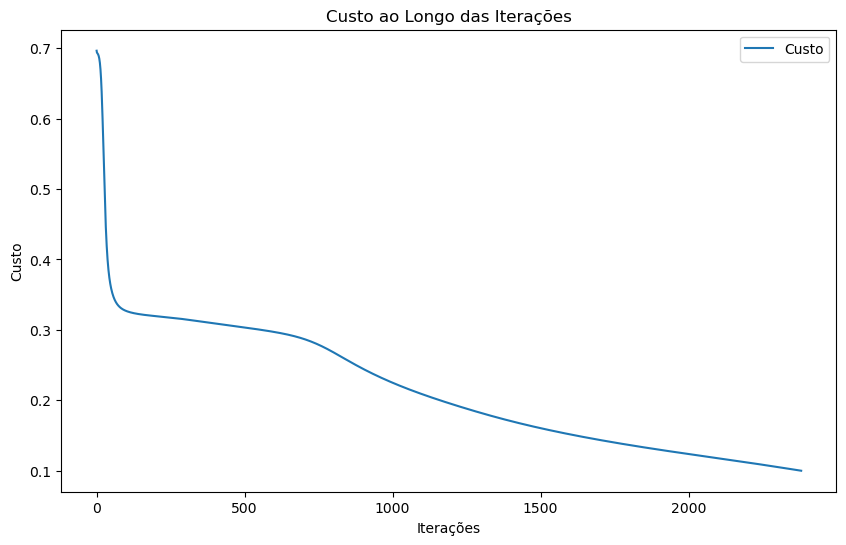

In [17]:
X = pd.read_csv('data/datasetX.csv')
X = normalize(X).values.tolist()
y = pd.read_csv('data/datasety.csv')
y = y['num'].tolist()

W1, b1, W2, b2 = train_and_evaluate(
    X, y, hidden_size=8, alpha=0.01, iterations=9999, tol=0.1,
    show_it=True # para printar a evolução nas iterações
)